In [114]:
import energyflow as ef
import numpy as np
import matplotlib.pyplot as plt

In [115]:
data = ef.zjets_delphes.load("Herwig", num_data=500000, pad=True, cache_dir='../data/zplusjets/',
                                       source='zenodo', which='all',
                                       include_keys=None, exclude_keys=None)

In [116]:
def handle_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [117]:
det_jets = data['sim_jets'][:, np.newaxis, :]
det_particles = data['sim_particles']
det_particles[..., 0] = det_particles[..., 0] * 100
det_particles[..., 1:3] = det_particles[..., 1:3] + det_jets[..., 1:3]
det_particles[..., 2] = handle_angle(det_particles[..., 2])
det_mults = data['sim_mults']
gen_jets = data['gen_jets'][:, np.newaxis, :]
gen_particles = data['gen_particles']
gen_particles[..., 0] = gen_particles[..., 0] * 100
gen_particles[...,1:3] = gen_particles[..., 1:3] + gen_jets[..., 1:3]
gen_particles[..., 2] = handle_angle(gen_particles[..., 2])
gen_mults = data['gen_mults']

In [132]:
det_mask = np.arange(det_particles.shape[1])[None, :] < det_mults[:, None]
gen_mask = np.arange(gen_particles.shape[1])[None, :] < gen_mults[:, None]

In [ ]:
def nth_largest_pt_mask(particles, n):
    """
    Returns a boolean mask to extract the particle with the n-th largest pt on axis 1.
    
    Args:
    particles: numpy array of shape (num_events, num_particles, 4)
    n: int, the rank of pt to select (1 for largest, 2 for second largest, etc.)
    
    Returns:
    mask: boolean numpy array of the same shape as particles
    """
    pt = particles[..., 0]
    rank = pt.argsort(axis=1)
    nth_largest_indices = rank[:, -n]
    mask = np.zeros_like(pt, dtype=bool)
    mask[np.arange(len(mask)), nth_largest_indices] = True
    return mask

In [133]:
det_jets[..., 2] = handle_angle(det_jets[..., 2])
det_jets = det_jets.squeeze()
flattened_det_particles = det_particles[det_mask]
gen_jets[..., 2] = handle_angle(gen_jets[..., 2])
gen_jets = gen_jets.squeeze()
flattened_gen_particles = gen_particles[gen_mask]

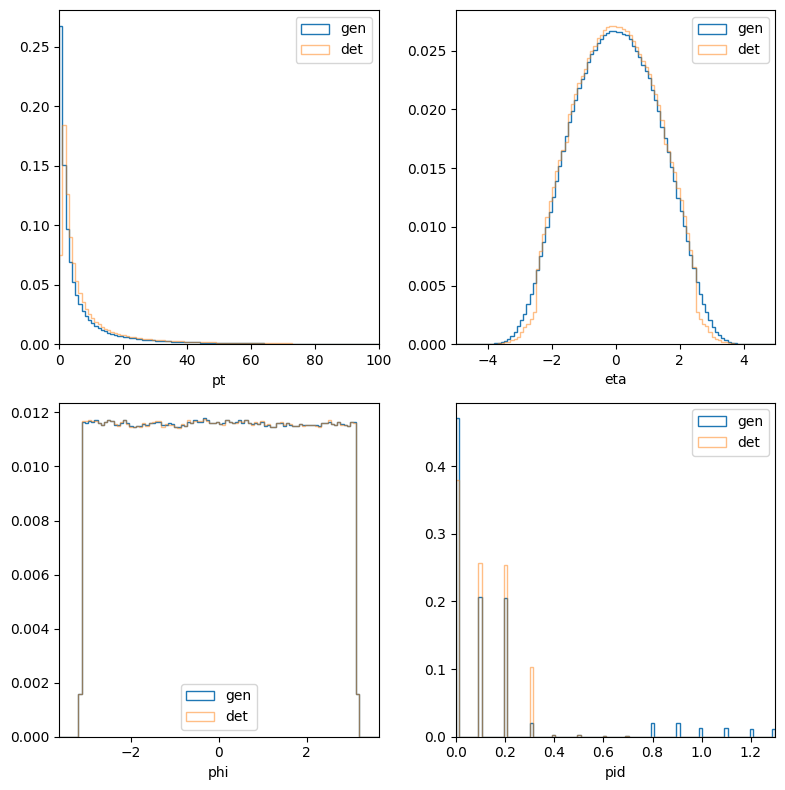

In [134]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['pt', 'eta', 'phi', 'pid']
x_limits = [(0, 100), (-5, 5), (-np.pi - 0.5, np.pi + 0.5), (0, 1.3)]
for i, ax in enumerate(ax.flatten()):
    
    gen_hist, bins = np.histogram(flattened_gen_particles[:, i], bins=100, range=x_limits[i])
    det_hist, _ = np.histogram(flattened_det_particles[:, i], bins=bins)
    
    gen_hist = gen_hist / np.sum(gen_hist)
    det_hist = det_hist / np.sum(det_hist)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step', alpha=0.5)
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    ax.legend()
fig.tight_layout()
plt.show()

In [135]:
MASS = 0.1
flattened_det_particles[..., -1] = MASS
flattened_gen_particles[..., -1] = MASS

In [136]:
def jetmomenta_to_fourmomenta(jetmomenta):
    pt, eta, phi, mass = jetmomenta.T

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(mass**2 + px**2 + py**2 + pz**2)

    fourmomenta = np.stack((E, px, py, pz), axis=-1)
    return fourmomenta

In [137]:
det_fourmomenta = jetmomenta_to_fourmomenta(flattened_det_particles)
det_jets_fourmomenta = jetmomenta_to_fourmomenta(det_jets)
gen_fourmomenta = jetmomenta_to_fourmomenta(flattened_gen_particles)
gen_jets_fourmomenta = jetmomenta_to_fourmomenta(gen_jets)

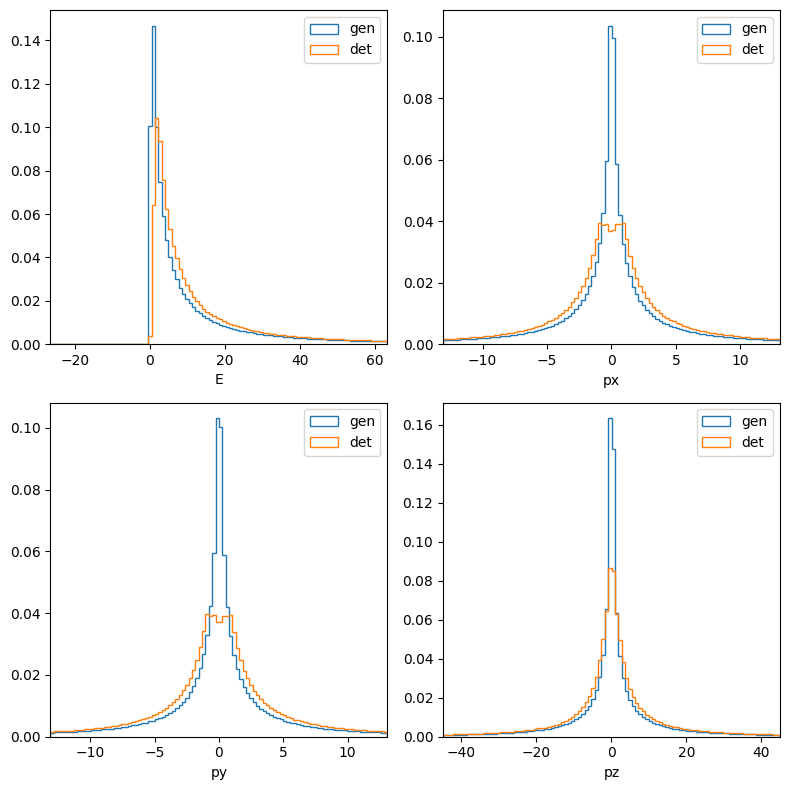

In [138]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['E', 'px', 'py', 'pz']
x_limits = [(0, 1), (0, 1), (-0.2, 0.2), (-0.2, 0.2)]
for i, ax in enumerate(ax.flatten()):
    mean = np.mean(gen_fourmomenta[:, i])
    std = np.std(gen_fourmomenta[:, i])
    x_lim = (mean - std, mean + std)
    gen_hist, bins = np.histogram(gen_fourmomenta[:, i], bins=100, range=x_lim)
    det_hist, _ = np.histogram(det_fourmomenta[:, i], bins=bins)
    
    gen_hist = gen_hist / np.sum(gen_hist)
    det_hist = det_hist / np.sum(det_hist)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step')
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_lim)
    
    ax.legend()
fig.tight_layout()
plt.show()

In [158]:
n = 2

In [159]:
det_pt_mask = nth_largest_pt_mask(det_particles, n)
gen_pt_mask = nth_largest_pt_mask(gen_particles, n)

In [160]:
det_first_particles = jetmomenta_to_fourmomenta(det_particles[det_pt_mask])
gen_first_particles = jetmomenta_to_fourmomenta(gen_particles[gen_pt_mask])

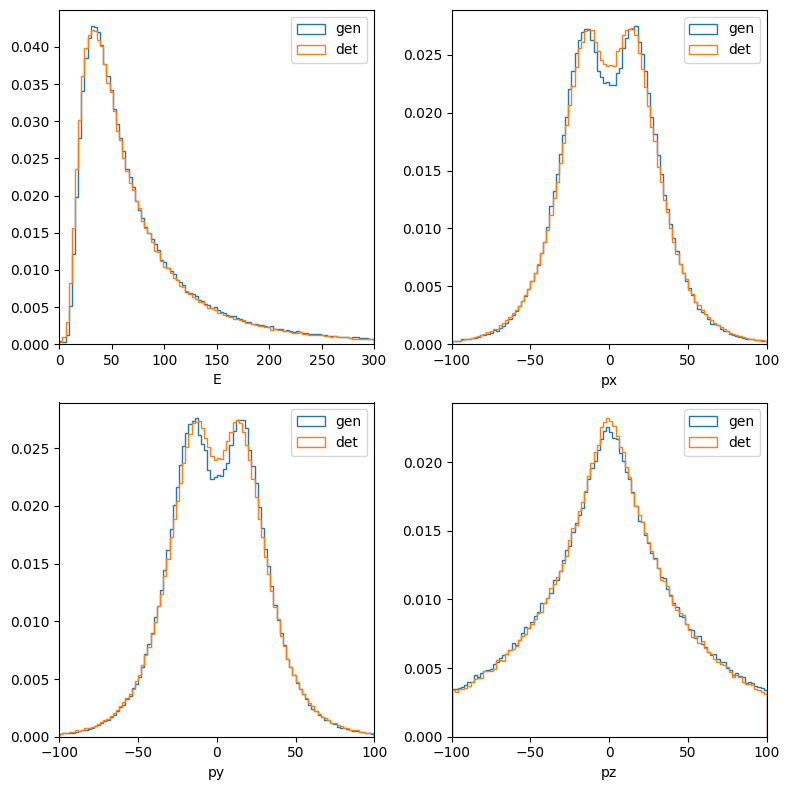

In [161]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['E', 'px', 'py', 'pz']
x_limits = [(0, 300), (-100, 100), (-100, 100), (-100, 100)]
for i, ax in enumerate(ax.flatten()):
    gen_hist, bins = np.histogram(gen_first_particles[:, i], bins=100, range=x_limits[i])
    det_hist, _ = np.histogram(det_first_particles[:, i], bins=bins)
    
    gen_hist = gen_hist / np.sum(gen_hist)
    det_hist = det_hist / np.sum(det_hist)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step')
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    
    ax.legend()
fig.tight_layout()
plt.show()

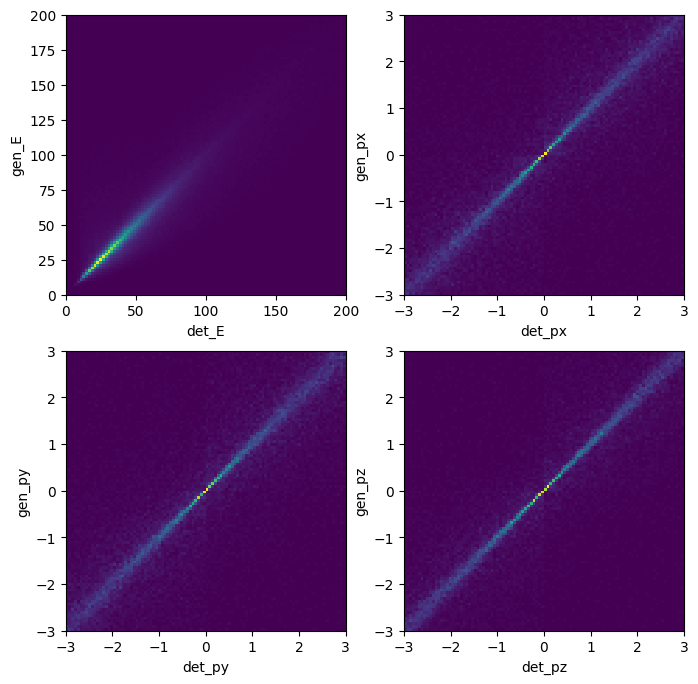

In [162]:
ig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['E', 'px', 'py', 'pz']
ax_limits = [(0, 200), (-3,3), (-3, 3), (-3, 3)]
for i, ax in enumerate(ax.flatten()):
    ax.hist2d(det_first_particles[:, i], gen_first_particles[:, i], bins=100, range = (ax_limits[i], ax_limits[i]))
    ax.set_xlabel('det_'+labels[i])
    ax.set_ylabel('gen_'+labels[i])
    ax.set_aspect('equal')
    ax.set_xlim(ax_limits[i])
    ax.set_ylim(ax_limits[i])
fig.tight_layout()
plt.show()